Setup

In [1]:
!pip -q install pandas numpy scikit-learn xgboost matplotlib seaborn joblib

Imports & Config

In [2]:
import os, json, warnings, joblib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Try XGBoost; fallback to GradientBoosting if not available
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    from sklearn.ensemble import GradientBoostingRegressor
    HAS_XGB = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

Generate a synthetic multi-store, multi-item dataset

In [3]:
#Original Dataset is too Large
def generate_synthetic(n_days=730, n_stores=5, n_items=15):
    dates = pd.date_range("2023-01-01", periods=n_days, freq="D")
    rows = []
    for store in range(1, n_stores + 1):
        for item in range(1, n_items + 1):
            # base yearly seasonality + weekday/weekend pattern + store/item biases + noise
            base = 20 + 6 * np.sin(np.arange(n_days) / 365 * 2 * np.pi)
            dow = pd.Series(dates).dt.dayofweek.values
            wknd = np.where(dow < 5, 1.0, 1.25)
            store_bias = 1 + (store - 1) * 0.06
            item_bias  = 1 + (item - 1) * 0.02
            promo = (np.random.rand(n_days) < 0.07).astype(float)  # random promo days
            promo_boost = 1 + promo * 0.35
            noise = np.random.normal(0, 1.5, n_days)
            sales = np.clip(base * wknd * store_bias * item_bias * promo_boost + noise, 0, None)
            rows.append(pd.DataFrame({
                "date": dates,
                "store": str(store),
                "item": str(item),
                "sales": sales.round(2)
            }))
    df = pd.concat(rows, ignore_index=True)
    return df

# small & fast by default; increase if you want
df = generate_synthetic(n_days=540, n_stores=5, n_items=12)
df.to_csv("data/sales.csv", index=False)
df.head(), df.tail(), df.shape

(        date store item  sales
 0 2023-01-01     1    1  25.18
 1 2023-01-02     1    1  20.87
 2 2023-01-03     1    1  21.27
 3 2023-01-04     1    1  18.62
 4 2023-01-05     1    1  18.11,
             date store item  sales
 32395 2024-06-19     5   12  33.42
 32396 2024-06-20     5   12  32.22
 32397 2024-06-21     5   12  31.15
 32398 2024-06-22     5   12  40.26
 32399 2024-06-23     5   12  41.40,
 (32400, 4))

EDA

Date range: 2023-01-01 → 2024-06-23
Rows: 32400 Unique stores: 5 Unique items: 12


,date,store,item,sales
0,2023-01-01,1,1,25.18
1,2023-01-02,1,1,20.87
2,2023-01-03,1,1,21.27
3,2023-01-04,1,1,18.62
4,2023-01-05,1,1,18.11


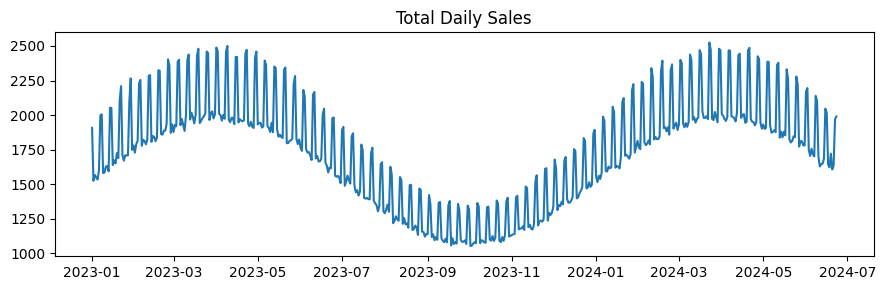

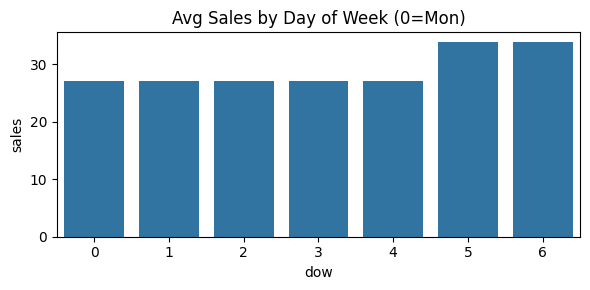

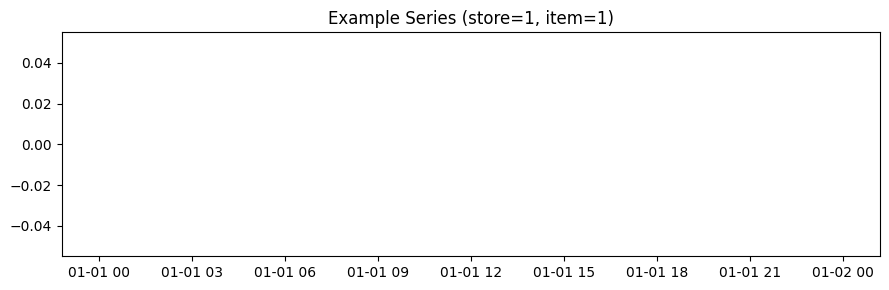

In [4]:
df = pd.read_csv("data/sales.csv", parse_dates=["date"])
df = df.sort_values(["store","item","date"]).reset_index(drop=True)

print("Date range:", df["date"].min().date(), "→", df["date"].max().date())
print("Rows:", len(df), "Unique stores:", df["store"].nunique(), "Unique items:", df["item"].nunique())
display(df.head())

# total daily sales
daily = df.groupby("date", as_index=False)["sales"].sum()
plt.figure(figsize=(9,3))
plt.plot(daily["date"], daily["sales"])
plt.title("Total Daily Sales")
plt.tight_layout(); plt.show()

# average by day of week
tmp = df.copy()
tmp["dow"] = tmp["date"].dt.dayofweek
plt.figure(figsize=(6,3))
sns.barplot(x="dow", y="sales", data=tmp, estimator=np.mean, errorbar=None)
plt.title("Avg Sales by Day of Week (0=Mon)")
plt.tight_layout(); plt.show()

# one example series
ex = df[(df["store"]=="1") & (df["item"]=="1")]
plt.figure(figsize=(9,3))
plt.plot(ex["date"], ex["sales"])
plt.title("Example Series (store=1, item=1)")
plt.tight_layout(); plt.show()

Feature Engineering

In [5]:
LAGS  = [1, 7, 14, 28]
ROLLS = [7, 14, 28]

def add_time_features(df_):
    df_ = df_.copy()
    df_["dow"] = df_["date"].dt.dayofweek
    df_["week"] = df_["date"].dt.isocalendar().week.astype(int)
    df_["month"] = df_["date"].dt.month
    df_["year"] = df_["date"].dt.year
    df_["is_weekend"] = (df_["dow"]>=5).astype(int)
    return df_

def make_supervised(df_):
    parts = []
    for (s,i), g in df_.groupby(["store","item"], as_index=False):
        g = g.sort_values("date").copy()
        for L in LAGS:
            g[f"lag_{L}"] = g["sales"].shift(L)
        for R in ROLLS:
            g[f"rmean_{R}"] = g["sales"].shift(1).rolling(R).mean()
        parts.append(g)
    out = pd.concat(parts, ignore_index=True)
    # drop early rows with NaNs from lags/rollings
    min_needed = max(max(LAGS), max(ROLLS))
    out = out[out["date"] >= (out["date"].min() + pd.Timedelta(days=min_needed))].copy()
    out = out.dropna().reset_index(drop=True)
    return out

df_fe = add_time_features(df)
df_fe = make_supervised(df_fe)
df_fe.head(), df_fe.shape

(        date  store  item  sales  dow  week  month  year  is_weekend  lag_1  \
 0 2023-01-29      1     1  30.92    6     4      1  2023           1  28.47   
 1 2023-01-30      1     1  28.81    0     5      1  2023           0  30.92   
 2 2023-01-31      1     1  20.41    1     5      1  2023           0  28.81   
 3 2023-02-01      1     1  22.97    2     5      2  2023           0  20.41   
 4 2023-02-02      1     1  31.82    3     5      2  2023           0  22.97   
 
    lag_7  lag_14  lag_28    rmean_7   rmean_14   rmean_28  
 0  25.01   26.42   25.18  23.372857  23.704286  23.845357  
 1  20.44   22.99   20.87  24.217143  24.025714  24.050357  
 2  19.26   22.60   21.27  25.412857  24.441429  24.333929  
 3  22.00   23.78   18.62  25.577143  24.285000  24.303214  
 4  23.58   20.38   18.11  25.715714  24.227143  24.458571  ,
 (30720, 16))

Train/Test Split (by time) + Feature Lists

In [6]:
FORECAST_HORIZON = 14  # holdout window for backtest

last_date = df_fe["date"].max()
test_start = last_date - pd.Timedelta(days=FORECAST_HORIZON - 1)

train_df = df_fe[df_fe["date"] < test_start].copy()
test_df  = df_fe[df_fe["date"] >= test_start].copy()

FEATURES_NUM = [c for c in df_fe.columns
                if c.startswith("lag_") or c.startswith("rmean_") or c in ["dow","week","month","year","is_weekend"]]
FEATURES_CAT = ["store","item"]
TARGET = "sales"

print("Train:", train_df.shape, "Test:", test_df.shape)

Train: (29880, 16) Test: (840, 16)


Preprocess + Model (XGBRegressor or fallback)

In [7]:
# OneHotEncoder API compatibility (newer vs older sklearn)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("cat", ohe, FEATURES_CAT),
        ("num", "passthrough", FEATURES_NUM)
    ]
)

if HAS_XGB:
    model = XGBRegressor(
        n_estimators=700,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_STATE,
        objective="reg:squarederror",
        tree_method="hist",
    )
else:
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(random_state=RANDOM_STATE)

pipe = Pipeline([("prep", pre), ("model", model)])

Time-Series Cross-Validation (on train only)

In [12]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as sk_mse, mean_absolute_error

def rmse(y_true, y_pred):
    return np.sqrt(sk_mse(y_true, y_pred))

tscv = TimeSeriesSplit(n_splits=5)

X_tr = train_df[FEATURES_CAT + FEATURES_NUM]
y_tr = train_df[TARGET]

cv_scores = []
for k, (tr_idx, va_idx) in enumerate(tscv.split(X_tr), start=1):
    X_trn, X_val = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
    y_trn, y_val = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]

    pipe.fit(X_trn, y_trn)
    pred = pipe.predict(X_val)

    s_rmse = rmse(y_val, pred)
    s_mae  = mean_absolute_error(y_val, pred)
    cv_scores.append((s_rmse, s_mae))

    print(f"Fold {k}: RMSE={s_rmse:.3f}, MAE={s_mae:.3f}")

cv_rmse = float(np.mean([rm for rm, _ in cv_scores]))
cv_mae  = float(np.mean([ma for _, ma in cv_scores]))
print(f"\nCV Mean: RMSE={cv_rmse:.3f}, MAE={cv_mae:.3f}")


Fold 1: RMSE=3.083, MAE=2.003
Fold 2: RMSE=3.208, MAE=2.032
Fold 3: RMSE=3.435, MAE=2.209
Fold 4: RMSE=3.445, MAE=2.176
Fold 5: RMSE=3.632, MAE=2.254

CV Mean: RMSE=3.360, MAE=2.135


Fit on full train & evaluate on holdout

Test: RMSE=3.014, MAE=1.989


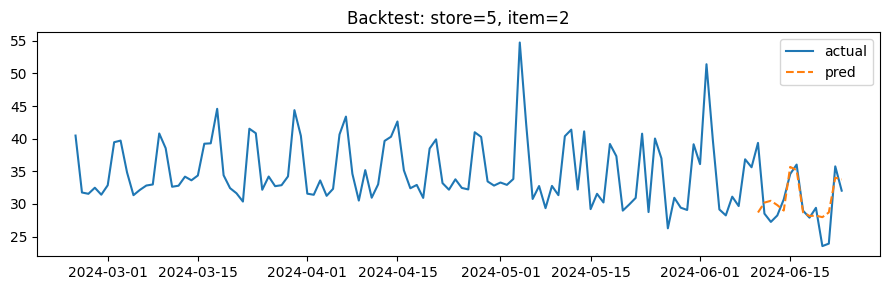

In [13]:
pipe.fit(train_df[FEATURES_CAT + FEATURES_NUM], train_df[TARGET])

pred_test = pipe.predict(test_df[FEATURES_CAT + FEATURES_NUM])

test_rmse = rmse(test_df[TARGET], pred_test)
test_mae  = mean_absolute_error(test_df[TARGET], pred_test)
print(f"Test: RMSE={test_rmse:.3f}, MAE={test_mae:.3f}")

# Plot a backtest for a random series in the test window
def plot_backtest(store_id, item_id, n_points=120):
    sub = df_fe[(df_fe["store"]==store_id) & (df_fe["item"]==item_id)].copy()
    sub = sub.sort_values("date")
    sub["pred"] = np.nan
    mask = sub["date"] >= test_start
    if mask.any():
        sub.loc[mask, "pred"] = pipe.predict(sub.loc[mask, FEATURES_CAT + FEATURES_NUM])
    tail = sub.tail(n_points)

    plt.figure(figsize=(9,3))
    plt.plot(tail["date"], tail["sales"], label="actual")
    plt.plot(tail["date"], tail["pred"], "--", label="pred")
    plt.title(f"Backtest: store={store_id}, item={item_id}")
    plt.legend(); plt.tight_layout(); plt.show()

row = test_df.sample(1, random_state=RANDOM_STATE).iloc[0]
plot_backtest(row["store"], row["item"])

Recursive forecasting utility (next H days for a given series)

,date,store,item,pred
0,2024-06-24,5,2,26.167770
1,2024-06-25,5,2,26.068254
2,2024-06-26,5,2,28.604773
3,2024-06-27,5,2,27.073830
4,2024-06-28,5,2,27.052704


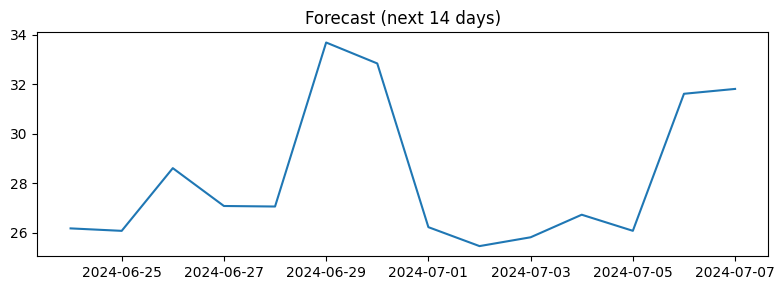

In [15]:
def forecast_next(df_hist, store_id, item_id, horizon=14,
                  lags=(1,7,14,28), rolls=(7,14,28)):
    """
    One-step-ahead recursive forecaster for a single (store,item).
    Assumes `pipe` is a fitted Pipeline and uses the same feature logic
    as training (lags/rollings + calendar).
    """
    # Normalize dtypes to avoid equality mismatches
    df = df_hist.copy()
    df["date"]  = pd.to_datetime(df["date"])
    df["store"] = df["store"].astype(str)
    df["item"]  = df["item"].astype(str)
    store_id, item_id = str(store_id), str(item_id)

    # Pull history for this series
    hist = df[(df["store"] == store_id) & (df["item"] == item_id)].sort_values("date")
    if hist.empty:
        raise ValueError(f"No history found for store='{store_id}', item='{item_id}'")

    # Need enough history for the largest lag/rolling window
    min_needed = max(max(lags), max(rolls))
    if (len(hist) < (min_needed + 1)):
        raise ValueError(
            f"Series too short for lags/rolls. Need ≥ {min_needed+1} rows, "
            f"found {len(hist)} for store={store_id}, item={item_id}."
        )

    # Work copy (we'll append predictions)
    work = hist[["date","store","item","sales"]].copy()
    preds = []

    for step in range(horizon):
        d = work["date"].max() + pd.Timedelta(days=1)

        # Append placeholder row
        row = pd.DataFrame({"date":[d], "store":[store_id], "item":[item_id], "sales":[np.nan]})
        tmp = pd.concat([work, row], ignore_index=True)

        # Feature engineering identical to training
        tmp = add_time_features(tmp)

        # Build supervised per group (same as training)
        parts = []
        for (s,i), g in tmp.groupby(["store","item"], as_index=False):
            g = g.sort_values("date").copy()
            for L in lags:
                g[f"lag_{L}"] = g["sales"].shift(L)
            for R in rolls:
                g[f"rmean_{R}"] = g["sales"].shift(1).rolling(R).mean()
            parts.append(g)
        tmp_sup = pd.concat(parts, ignore_index=True)

        # Drop early rows created by lags/rolls
        tmp_sup = tmp_sup[tmp_sup["date"] >= (tmp_sup["date"].min() + pd.Timedelta(days=min_needed))]

        # Use the **last** engineered row (the forecast day)
        new_row = tmp_sup.sort_values("date").tail(1)

        # Guard against empty selection
        if new_row.empty:
            raise RuntimeError(
                "Engineered row for the forecast day is empty. "
                "Check history length and feature windows."
            )

        # Feature lists (same as training)
        FEATURES_NUM = [c for c in new_row.columns
                        if c.startswith(("lag_","rmean_")) or c in ["dow","week","month","year","is_weekend"]]
        FEATURES_CAT = ["store","item"]

        # Predict and feed back
        yhat = float(pipe.predict(new_row[FEATURES_CAT + FEATURES_NUM])[0])
        preds.append({"date": d, "store": store_id, "item": item_id, "pred": yhat})
        work = pd.concat(
            [work, pd.DataFrame({"date":[d], "store":[store_id], "item":[item_id], "sales":[yhat]})],
            ignore_index=True
        )

    return pd.DataFrame(preds)

# Example call (same as before)
fc = forecast_next(df, str(row["store"]), str(row["item"]), horizon=14)
display(fc.head())
plt.figure(figsize=(8,3))
plt.plot(fc["date"], fc["pred"])
plt.title("Forecast (next 14 days)")
plt.tight_layout(); plt.show()


Save artifacts (pipeline + metadata + sample forecast)

In [16]:
joblib.dump(pipe, "models/sales_forecast_pipeline.joblib")

metadata = {
    "features_num": FEATURES_NUM,
    "features_cat": FEATURES_CAT,
    "horizon_days": FORECAST_HORIZON,
    "cv_rmse": float(cv_rmse),
    "cv_mae": float(cv_mae),
    "test_rmse": float(test_rmse),
    "test_mae": float(test_mae),
    "model": "XGBRegressor" if HAS_XGB else "GradientBoostingRegressor",
    "test_start": str(test_start.date())
}
with open("models/metadata.json","w") as f:
    json.dump(metadata, f, indent=2)

fc.to_csv("models/sample_forecast.csv", index=False)
print("Saved:")
print(" - models/sales_forecast_pipeline.joblib")
print(" - models/metadata.json")
print(" - models/sample_forecast.csv")


Saved:
 - models/sales_forecast_pipeline.joblib
 - models/metadata.json
 - models/sample_forecast.csv
